# Introduction to encoding textual data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pymongo
from nltk.tokenize import sent_tokenize
from datasets import load_dataset

# Remember to start Mongo with sudo systemctl start mongod

In [ ]:
# Load dataset into DB

db = pymongo.MongoClient()['climate']
ds = load_dataset("tdiggelm/climate_fever")

evidences = []
for record in ds['test']:
    for evidence in record['evidences']:
        evidence['claim_id'] = record['claim_id']
        evidence['claim'] = record['claim']
        evidence['claim_label'] = record['claim_id']
        evidences.append(evidence)

db['evidences'].insert_many(evidences)


In [5]:
# Load dataset from DB

db = pymongo.MongoClient()['climate']
collection = db['evidences']
records = list(collection.find({}, {'_id': 0, 'evidence': 1}))
docs = [doc['evidence'].strip('.').strip('"').lower() for doc in records]
print(f"Corpus size: {len(docs)}")
print(f"Corpus sample: {docs[0]}")

Corpus size: 7675
Corpus sample: recent research shows human activity driving earth towards global extinction event


In [10]:
def type_token(text: str, ratio: bool = False) -> float:
    tokens = text.split()
    if not tokens:
        return 0
    types = set(tokens)
    return len(types)/len(tokens) if ratio else len(types)

def features(text, ratio: bool = False):
    return np.array([len(text), type_token(text, ratio)])

In [11]:
D = np.array([features(d, ratio=True) for d in docs])
D

array([[ 82.        ,   1.        ],
       [178.        ,   0.88      ],
       [110.        ,   1.        ],
       ...,
       [163.        ,   0.96296296],
       [ 95.        ,   1.        ],
       [131.        ,   0.92      ]], shape=(7675, 2))

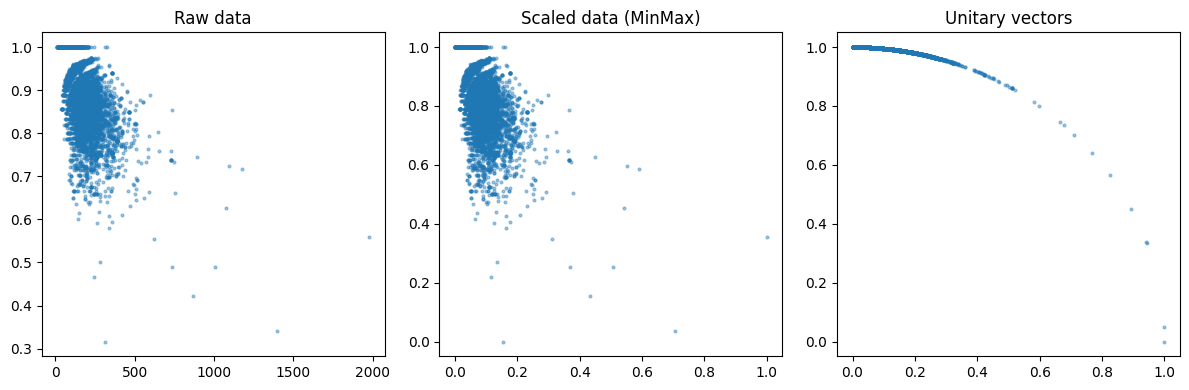

In [12]:
scaler = MinMaxScaler()
S = scaler.fit_transform(D)
row_norms = np.linalg.norm(S, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1
U = S / row_norms


fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].scatter(D[:,0], D[:,1], s=4, alpha=.4)
ax[0].set_title('Raw data')
ax[1].scatter(S[:,0], S[:,1], s=4, alpha=.4)
ax[1].set_title('Scaled data (MinMax)')
ax[2].scatter(U[:,0], U[:,1], s=4, alpha=.4)
ax[2].set_title('Unitary vectors')
plt.tight_layout()
plt.show()